# **COMP9517 - Group Project (Segmentation Models Pytorch)**

## **0. Add Imports**

In [1]:
# !conda env create -f environment.yaml

In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, RichProgressBar, RichModelSummary
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

from data import AerialDeadTreeSegDataModule, download_dataset
from lightning.pytorch.tuner import Tuner
from lightning_modules import SMPLitModule
from models import FreezeSMPEncoderUtils
from utils import paths,TimerCallback
import segmentation_models_pytorch as smp


In [3]:
ARCH = "UNet"
ENCODER_NAME = "mit_b5"
VERSION = "val_transform_test2"
TARGET_SIZE = 256
LOSS1 = smp.losses.JaccardLoss(mode='binary', from_logits=True)
LOSS2 = smp.losses.FocalLoss(mode='binary')

## **1. Simple Summary of the Dattaset**

In [4]:
from PIL import Image
# Get the data folder
data_folder = download_dataset()

rgb_dir = os.path.join(data_folder, "RGB_images")
nrg_dir = os.path.join(data_folder, "NRG_images")
mask_dir = os.path.join(data_folder, "masks")

# Get the max and min resolution of the images
def get_max_min_resolution(image_dir):
    max_res = (0, 0)
    min_res = (float('inf'), float('inf'))
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            filepath = os.path.join(image_dir, filename)
            with open(filepath, 'rb') as f:
                img = Image.open(f)
                height, width = img.size
                max_res = (max(max_res[0], height), max(max_res[1], width))
                min_res = (min(min_res[0], height), min(min_res[1], width))
    return max_res, min_res
max_rgb_res, min_rgb_res = get_max_min_resolution(rgb_dir)
max_nrg_res, min_nrg_res = get_max_min_resolution(nrg_dir)
print(f"Max RGB resolution: {max_rgb_res}, Min RGB resolution: {min_rgb_res}")
print(f"Max NRG resolution: {max_nrg_res}, Min NRG resolution: {min_nrg_res}")

Max RGB resolution: (652, 636), Min RGB resolution: (317, 294)
Max NRG resolution: (652, 636), Min NRG resolution: (317, 294)


## **1. Find Suggested Learning Rate**

In [5]:
data_module = AerialDeadTreeSegDataModule(
    val_split=0.1, test_split=0.2, seed=42,
    modality="merged", # in_channels=4. If modality is "merged", it will use 4 channels (RGB + NIR); Otherwise, it will use 3 channels (RGB).
    batch_size=32,
    num_workers= int(os.cpu_count() / 2) if os.cpu_count() is not None else 0,
    target_size=TARGET_SIZE)

In [6]:
model = SMPLitModule(
    arch=ARCH,
    encoder_name=ENCODER_NAME,
    encoder_weights="imagenet",
    in_channels=data_module.in_channels,
    out_classes=1,  # Binary segmentation
    loss1=LOSS1,
    loss2=LOSS2,
    lr=1e-3,
    use_scheduler=False
)

layer_names = []
for name, module in model.model.encoder.named_children():
    print(f"Layer: {name}, Module: {module}")
    layer_names.append(name)

print("\nEncoder Layer Names:" + str(layer_names))

Layer: patch_embed1, Module: OverlapPatchEmbed(
  (proj): Conv2d(4, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
)
Layer: patch_embed2, Module: OverlapPatchEmbed(
  (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)
Layer: patch_embed3, Module: OverlapPatchEmbed(
  (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
)
Layer: patch_embed4, Module: OverlapPatchEmbed(
  (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)
Layer: block1, Module: Sequential(
  (0): Block(
    (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (q): Linear(in_features=64, out_features=64, bias=True)
      (kv): Linear(in_features=64, ou

In [7]:
# freeze_tool = FreezeSMPEncoderUtils()
# freeze_tool(model, ENCODER_NAME, layers_range=(1, 2))  # Freeze the 2nd layers

In [8]:
trainer = L.Trainer(
    log_every_n_steps=5
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/leo/apps/miniconda3/envs/CVers/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Using existing split: ../data_splits/data_split_42_70_10.csv

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.002089296130854039
Restoring states from the checkpoint path at /home/leo/unsw/comp9517/CV9517_Group-Project/notebooks/.lr_find_5bac34d6-58b7-4c92-80ab-1fc0fce3e67e.ckpt
Restored all states from the checkpoint at /home/leo/unsw/comp9517/CV9517_Group-Project/notebooks/.lr_find_5bac34d6-58b7-4c92-80ab-1fc0fce3e67e.ckpt


Teardown called, cleaning up datasets...

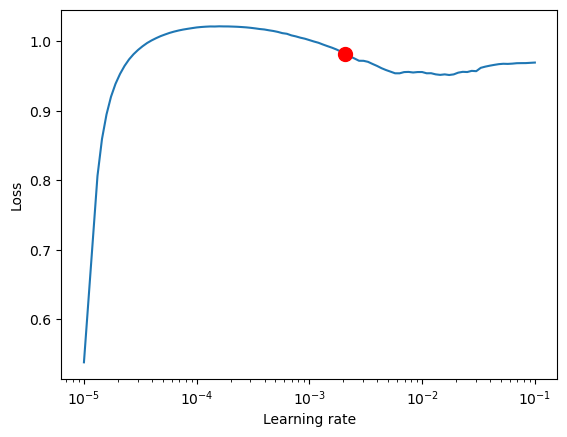

/tmp/ipykernel_842785/1558274056.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [9]:
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model, datamodule=data_module,
                          min_lr=1e-5, max_lr= 0.1,
                          num_training=100, early_stop_threshold=4)
fig = lr_finder.plot(suggest=True, show=True)
fig.show()

In [10]:
import math
suggested_lr = lr_finder.suggestion()
print(f"Original suggested learning rate: {suggested_lr}")

# Round the suggested learning rate to 1 significant digit
magnitude =  10 ** (math.floor(math.log10(suggested_lr)))
suggested_lr = round(suggested_lr / magnitude) * magnitude

print(f"Rounded suggested learning rate: {suggested_lr}")

Original suggested learning rate: 0.002089296130854039
Rounded suggested learning rate: 0.002


## **3. Train Segmentation Model**

In [11]:
data_module =  AerialDeadTreeSegDataModule(
    val_split=0.1, test_split=0.2, seed=42,
    modality="merged", # in_channels=4. If modality is "merged", it will use 4 channels (RGB + NIR); Otherwise, it will use 3 channels (RGB).
    batch_size=32,
    num_workers= int(os.cpu_count() / 2) if os.cpu_count() is not None else 0,
    target_size=TARGET_SIZE)

In [12]:
model_sum_callback = RichModelSummary(max_depth=2)

lr_monitor = LearningRateMonitor(logging_interval='step')

early_stop_callback = EarlyStopping(
    monitor="per_image_iou/val",
    patience=10,
    verbose=True,
    mode="max"  # Maximize the metric
)

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(paths.checkpoint_dir, f"smp_{ENCODER_NAME}_{ARCH}", VERSION),
    monitor="per_image_iou/val",
    filename="{epoch:02d}-{per_image_iou_val:.4f}",
    mode="max",
    save_top_k=3,
    enable_version_counter=True,
)

timer = TimerCallback()

In [13]:
model = SMPLitModule(
    arch=ARCH,
    encoder_name=ENCODER_NAME,
    encoder_weights="imagenet",
    in_channels=data_module.in_channels,
    out_classes=1,  # Binary segmentation
    loss1=LOSS1,
    loss2=LOSS2,
    lr=suggested_lr,
    use_scheduler=True
)

layer_names = []
for name, module in model.model.encoder.named_children():
    layer_names.append(name)
print(f"Encoder layer names: {layer_names}")


Encoder layer names: ['patch_embed1', 'patch_embed2', 'patch_embed3', 'patch_embed4', 'block1', 'norm1', 'block2', 'norm2', 'block3', 'norm3', 'block4', 'norm4']


In [14]:
# freeze_tool = FreezeSMPEncoderUtils()
# freeze_tool(model, ENCODER_NAME, layers_range=(0, 2))  # Freeze the first 2 layers

In [15]:
logger = TensorBoardLogger(paths.tensorboard_log_dir, name=f"smp_{ENCODER_NAME}_{ARCH}", version=VERSION)

trainer = L.Trainer(
    max_epochs=100,
    enable_progress_bar=True,
    logger=logger,
    callbacks=[model_sum_callback,lr_monitor, early_stop_callback, checkpoint_callback],
    log_every_n_steps=5,
)
trainer.fit(model, datamodule=data_module)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using existing split: ../data_splits/data_split_42_70_10.csv

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                    ┃ Type                        ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                   │ Unet                        │ 84.7 M │ train │
│ 1 │ model.encoder           │ MixVisionTransformerEncoder │ 81.4 M │ train │
│ 2 │ model.decoder           │ UnetDecoder                 │  3.3 M │ train │
│ 3 │ model.segmentation_head │ SegmentationHead            │    145 │ train │
│ 4 │ loss_fn1                │ JaccardLoss                 │      0 │ train │
│ 5 │ loss_fn2                │ FocalLoss                   │      0 │ train │
│ 6 │ _default_loss           │ DiceLoss                    │      0 │ train │
└───┴─────────────────────────┴─────────────────────────────┴────────┴───────┘

Trainable params: 84.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 84.7 M                                                                                               
Total estimated model params size (MB): 338                                                                        
Modules in train mode: 1086                                                                                        
Modules in eval mode: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.001 >= min_delta = 0.0. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.036 >= min_delta = 0.0. New best score: 0.055


Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.113 >= min_delta = 0.0. New best score: 0.168


Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.025 >= min_delta = 0.0. New best score: 0.193


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.017 >= min_delta = 0.0. New best score: 0.210


Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.004 >= min_delta = 0.0. New best score: 0.214


Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.047 >= min_delta = 0.0. New best score: 0.260


Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.083 >= min_delta = 0.0. New best score: 0.344


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.008 >= min_delta = 0.0. New best score: 0.351


Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.026 >= min_delta = 0.0. New best score: 0.377


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.000 >= min_delta = 0.0. New best score: 0.377


Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.014 >= min_delta = 0.0. New best score: 0.391


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric per_image_iou/val improved by 0.020 >= min_delta = 0.0. New best score: 0.412


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric per_image_iou/val did not improve in the last 10 records. Best score: 0.412. Signaling Trainer to stop.


Teardown called, cleaning up datasets...